Train sequences shape: (4026, 50, 5), Train targets shape: (4026, 5, 5)
Validation sequences shape: (861, 50, 5), Validation targets shape: (861, 5, 5)
Test sequences shape: (863, 50, 5), Test targets shape: (863, 5, 5)
Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0251 - val_loss: 0.0011
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 85us/step - loss: 0.0021 - val_loss: 0.0019
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0029 - val_loss: 6.1787e-04
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 62us/step - loss: 0.0015 - val_loss: 0.0015
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0020 - val_loss: 4.8100e-04
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 67us/step - loss: 0.0013 - val_loss: 8.9758e-04
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0015 - val_loss: 4.3126e-04
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 72us/step - loss: 0.0018 - val_loss: 9.2314e-04
Epoch 9/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0014 -

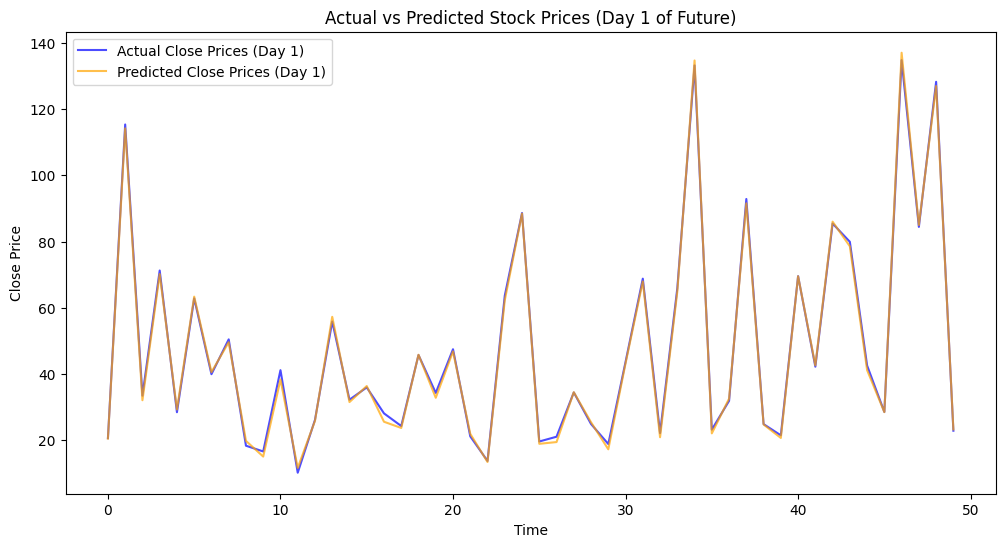

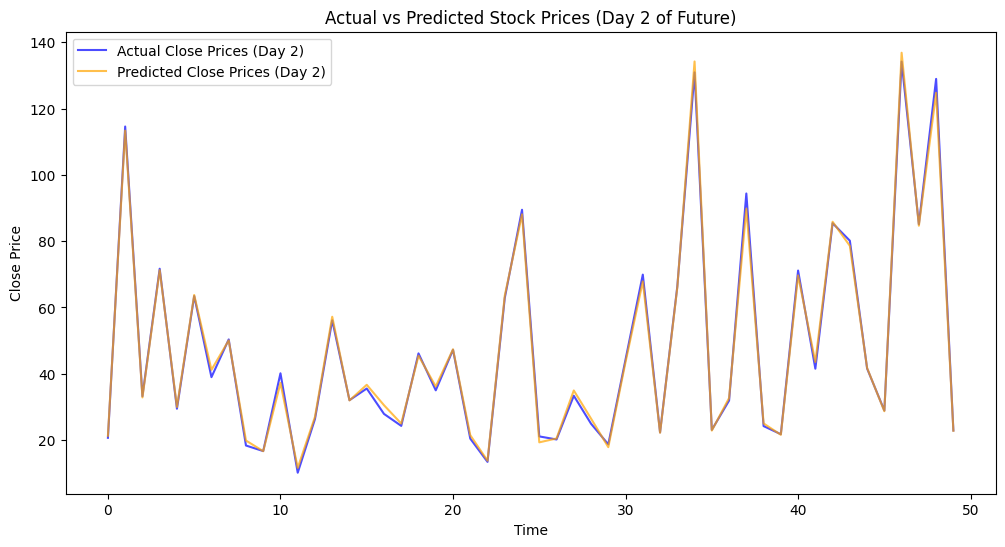

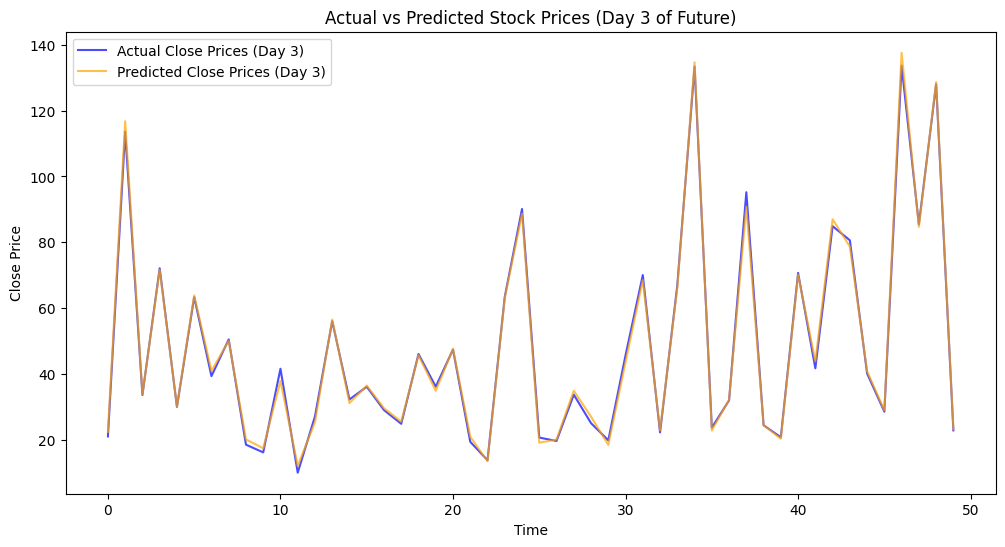

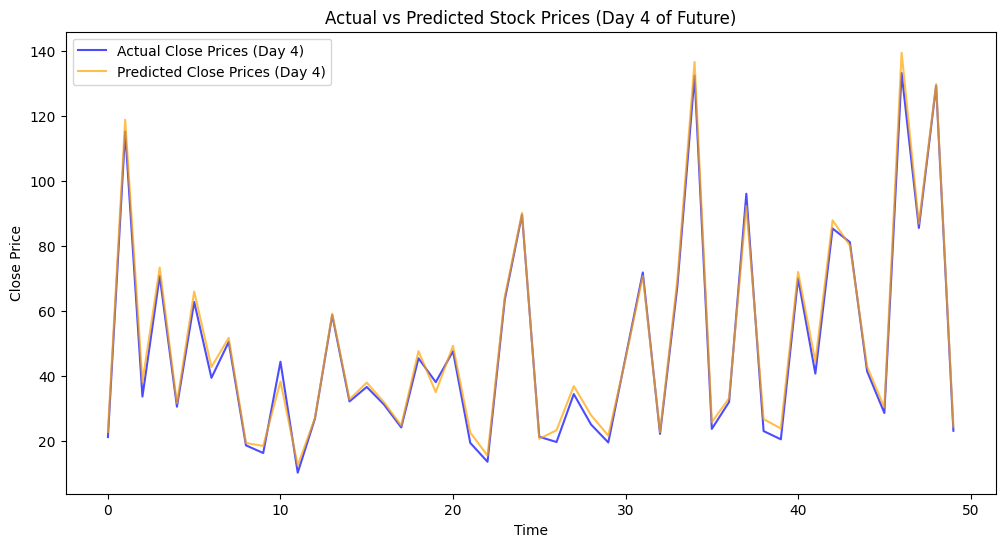

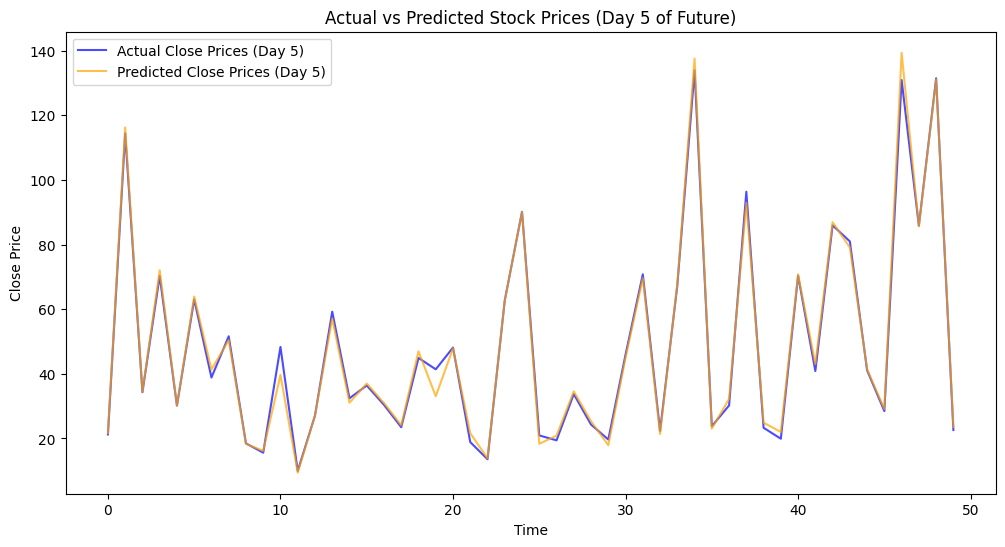

In [45]:
# I acknowledge using Machine Learning tools to generate parts of this code
# Vanilla RNN

import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings  # Suppress warnings
warnings.filterwarnings("ignore")

# Load the dataset
file_path = '/Users/bhaveshkorde/Desktop/Deep_learning/assignment_3/archive/A.csv'  
data = pd.read_csv(file_path, parse_dates=['Date'])

# Define feature columns explicitly
feature_columns = ['Open', 'High', 'Low', 'Close', 'Volume']  # Include Close for prediction
features = data[feature_columns].values

# Normalize the features
scaler = MinMaxScaler()
features = scaler.fit_transform(features)

# Adjust Hyperparameters
N = 50  # Number of past days
M = 5   # Number of future days
rnn_units = 200  # Number of RNN units
learning_rate = 0.001  # Learning rate
epochs = 50  # Number of epochs
batch_size = 32  # Batch size

# Function to create sequences for N past days and M future days
def create_sequences(data, sequence_length, prediction_length):
    X, y = [], []
    for i in range(len(data) - sequence_length - prediction_length + 1):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length:i + sequence_length + prediction_length, :])
    return np.array(X), np.array(y)

# Create sequences for the dataset
X, y = create_sequences(features, N, M)

# Split the dataset into training (70%), validation (15%), and testing (15%)
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.176, random_state=42)  # 0.176 * 0.85 ≈ 15%

# Validate the splits
print(f"Train sequences shape: {X_train.shape}, Train targets shape: {y_train.shape}")
print(f"Validation sequences shape: {X_val.shape}, Validation targets shape: {y_val.shape}")
print(f"Test sequences shape: {X_test.shape}, Test targets shape: {y_test.shape}")

def create_rnn_model(units, output_steps, num_features):
    inputs = tf.keras.layers.Input(shape=(N, num_features))
    rnn_output = tf.keras.layers.SimpleRNN(units, return_sequences=False)(inputs)
    dropout_output = tf.keras.layers.Dropout(0.4)(rnn_output)
    dense_output = tf.keras.layers.Dense(output_steps * num_features)(dropout_output)
    reshaped_output = tf.keras.layers.Reshape((output_steps, num_features))(dense_output)
    model = tf.keras.Model(inputs, reshaped_output)
    return model

# Instantiate and compile the model
model = create_rnn_model(rnn_units, M, len(feature_columns))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mean_squared_error')

# Train the model
steps_per_epoch = len(X_train) // batch_size
validation_steps = max(1, len(X_val) // batch_size)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(buffer_size=1000).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    ]
)

# Make predictions if test data is available
if len(X_test) > 0:
    predicted = model.predict(X_test)
    predicted_prices = scaler.inverse_transform(predicted.reshape(-1, len(feature_columns))).reshape(-1, M, len(feature_columns))
    actual_prices = scaler.inverse_transform(y_test.reshape(-1, len(feature_columns))).reshape(-1, M, len(feature_columns))
    
    # Compute MSE and RMSE
    mse_value = tf.keras.losses.MeanSquaredError()(actual_prices[:, :, 3], predicted_prices[:, :, 3]).numpy()
    rmse_value = np.sqrt(mse_value)
    print(f"Mean Squared Error (Close Prices): {mse_value:.6f}")
    print(f"Root Mean Squared Error (Close Prices): {rmse_value:.6f}")

    # Custom accuracy metric
    def accuracy_within_percentage(actual, predicted, percentage=5):
        diff = np.abs(actual - predicted)
        within_range = diff <= (percentage / 100) * actual
        accuracy = np.mean(within_range) * 100
        return accuracy

    # Compute and display accuracy for all predicted days
    for day in range(M):
        accuracy_day = accuracy_within_percentage(actual_prices[:, day, 3], predicted_prices[:, day, 3])
        print(f"Accuracy for Day {day + 1} Closing Prices within 5%: {accuracy_day:.2f}%")

    # Plot a subset of actual vs predicted Close prices for each day in the prediction horizon
    for day in range(M):
        plt.figure(figsize=(12, 6))
        plt.plot(actual_prices[:50, day, 3], label=f"Actual Close Prices (Day {day + 1})", color='blue', alpha=0.7)
        plt.plot(predicted_prices[:50, day, 3], label=f"Predicted Close Prices (Day {day + 1})", color='orange', alpha=0.7)
        plt.legend()
        plt.title(f"Actual vs Predicted Stock Prices (Day {day + 1} of Future)")
        plt.xlabel("Time")
        plt.ylabel("Close Price")
        plt.show()


else:
    print("Insufficient test sequences to make predictions.")


Train sequences shape: (4026, 50, 5), Train targets shape: (4026, 5, 5)
Validation sequences shape: (861, 50, 5), Validation targets shape: (861, 5, 5)
Test sequences shape: (863, 50, 5), Test targets shape: (863, 5, 5)
Epoch 1/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0118 - val_loss: 6.5165e-04 - learning_rate: 0.0050
Epoch 2/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 129us/step - loss: 8.0749e-04 - val_loss: 0.0011 - learning_rate: 0.0050
Epoch 3/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0011 - val_loss: 4.4584e-04 - learning_rate: 0.0050
Epoch 4/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 107us/step - loss: 0.0019 - val_loss: 7.1539e-04 - learning_rate: 0.0050
Epoch 5/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 9.1732e-04 - val_loss: 3.8787e-04 - learning_rate: 0.0050
Epoch 6/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 103us/step - loss: 0.0011 - val_loss: 7.2786e-04 - learning_rate: 0.0050
Epoch 7/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 7.1882e-04 - val_loss:

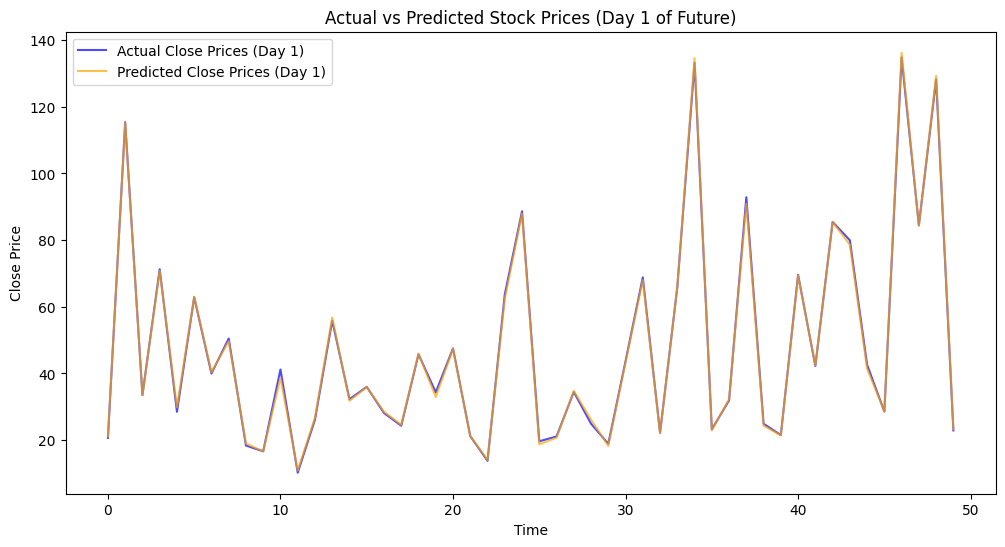

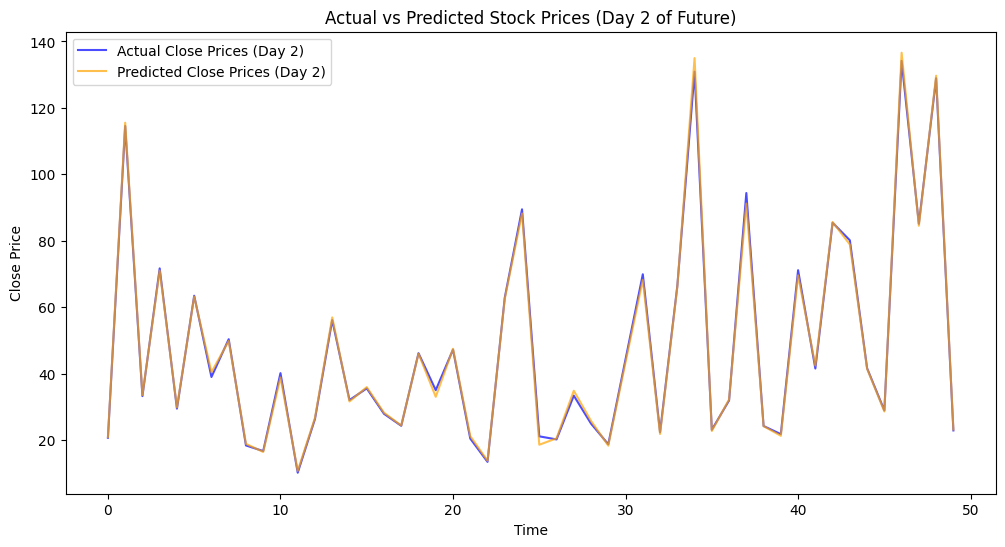

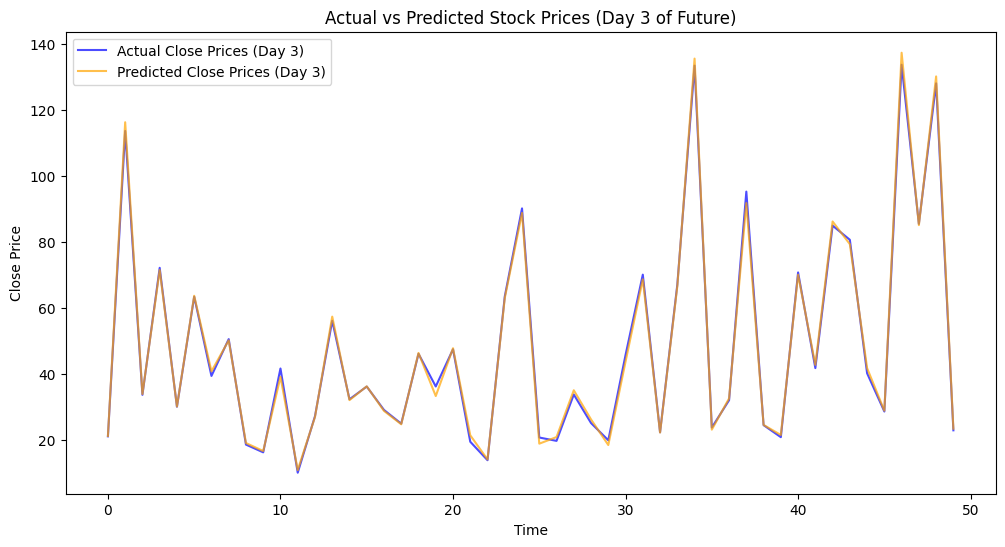

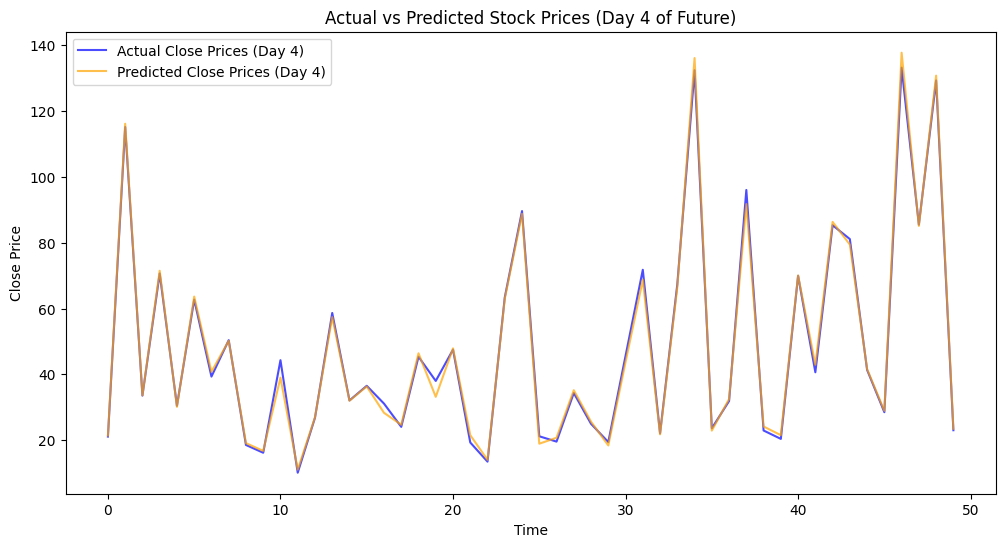

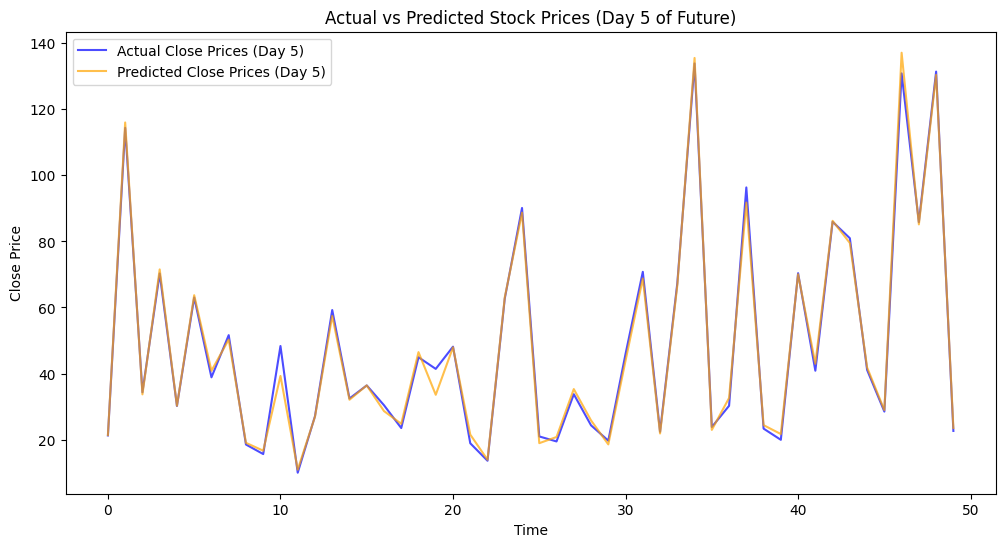

In [42]:
# LSTM

# LSTM

import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings  # Suppress warnings
warnings.filterwarnings("ignore")

# Load the dataset
file_path = '/Users/bhaveshkorde/Desktop/Deep_learning/assignment_3/archive/A.csv'  
data = pd.read_csv(file_path, parse_dates=['Date'])

# Define feature columns explicitly
feature_columns = ['Open', 'High', 'Low', 'Close', 'Volume']  # Include Close for prediction
features = data[feature_columns].values

# Normalize the features
scaler = MinMaxScaler()
features = scaler.fit_transform(features)

# Adjust Hyperparameters
N = 50  # Number of past days
M = 5    # Number of future days
rnn_units = 128  # Reduced LSTM units for faster training
learning_rate = 0.005  # Learning rate
epochs = 30  # Reduced number of epochs
batch_size = 32  # Batch size

# Function to create sequences for N past days and M future days
def create_sequences(data, sequence_length, prediction_length):
    X, y = [], []
    for i in range(len(data) - sequence_length - prediction_length + 1):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length:i + sequence_length + prediction_length, :])
    return np.array(X), np.array(y)

# Create sequences for the dataset
X, y = create_sequences(features, N, M)

# Split the dataset into training (70%), validation (15%), and testing (15%)
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.176, random_state=42)  # 0.176 * 0.85 ≈ 15%

# Validate the splits
print(f"Train sequences shape: {X_train.shape}, Train targets shape: {y_train.shape}")
print(f"Validation sequences shape: {X_val.shape}, Validation targets shape: {y_val.shape}")
print(f"Test sequences shape: {X_test.shape}, Test targets shape: {y_test.shape}")

# Define a simple LSTM model with Dropout
def create_simple_lstm_model(units, output_steps, num_features):
    inputs = tf.keras.layers.Input(shape=(N, num_features))
    lstm_output = tf.keras.layers.LSTM(units, return_sequences=False)(inputs)
    dropout_output = tf.keras.layers.Dropout(0.3)(lstm_output)  # Reduced dropout for smaller model
    dense_output = tf.keras.layers.Dense(output_steps * num_features)(dropout_output)
    reshaped_output = tf.keras.layers.Reshape((output_steps, num_features))(dense_output)
    model = tf.keras.Model(inputs, reshaped_output)
    return model

# Instantiate and compile the model
model = create_simple_lstm_model(rnn_units, M, len(feature_columns))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss=tf.keras.losses.MeanSquaredError())

# Prepare datasets for training
steps_per_epoch = len(X_train) // batch_size
validation_steps = max(1, len(X_val) // batch_size)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(buffer_size=1000).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
    ]
)

# Make predictions if test data is available
if len(X_test) > 0:
    predicted = model.predict(X_test)
    predicted_prices = scaler.inverse_transform(predicted.reshape(-1, len(feature_columns))).reshape(-1, M, len(feature_columns))
    actual_prices = scaler.inverse_transform(y_test.reshape(-1, len(feature_columns))).reshape(-1, M, len(feature_columns))
    mse_value = tf.keras.losses.MeanSquaredError()(actual_prices[:, :, 3], predicted_prices[:, :, 3]).numpy()
    print(f"Mean Squared Error (Close Prices): {mse_value:.6f}")

    # Calculate accuracy within 5% tolerance for each day
    for day in range(M):
        day_actual = actual_prices[:, day, 3]
        day_predicted = predicted_prices[:, day, 3]
        tolerance = 0.05 * day_actual
        accuracy = np.mean(np.abs(day_actual - day_predicted) <= tolerance) * 100
        print(f"Accuracy for Day {day + 1} Closing Prices within 5%: {accuracy:.2f}%")

    # Plot actual vs predicted Close prices for each day in the prediction horizon
    for day in range(M):
        plt.figure(figsize=(12, 6))
        plt.plot(actual_prices[:50, day, 3], label=f"Actual Close Prices (Day {day + 1})", color='blue', alpha=0.7)
        plt.plot(predicted_prices[:50, day, 3], label=f"Predicted Close Prices (Day {day + 1})", color='orange', alpha=0.7)
        plt.legend()
        plt.title(f"Actual vs Predicted Stock Prices (Day {day + 1} of Future)")
        plt.xlabel("Time")
        plt.ylabel("Close Price")
        plt.show()

else:
    print("Insufficient test sequences to make predictions.")
